<a href="https://colab.research.google.com/github/avisinghal6/Graph_Similarity/blob/main/MLGraphs_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 6.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━

In [1]:
from datasets import load_dataset
import networkx.algorithms.isomorphism as iso
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np
import itertools
import time
dataset_hf = load_dataset("graphs-datasets/MUTAG")
# For the train set (replace by valid or test as needed)
dataset_pg_list = [Data(graph) for graph in dataset_hf["train"]]
dataset_pg = DataLoader(dataset_pg_list)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/graphs-datasets___json/graphs-datasets--MUTAG-25292001ba5e0051/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

0


In [ ]:
def get_subgraphs(size,my_dataset):
  start=time.time()
  ans=[]
  for trial_graph in my_dataset:
    edge_index=trial_graph.x['edge_index'] #getting edges
    node_feat=trial_graph.x['node_feat']   #getting nodes
    edge_attr=trial_graph.x['edge_attr']   #getting edge attributes
    #removing 1 hot encoding on node features
    node_feat=np.array(node_feat)           
    node_feat=np.where(node_feat==1)[1]
    #getting unique codes
    unique_nodes=np.unique(node_feat)
    #removing 1 hot encoding on edge features
    edge_attr=np.array(edge_attr)
    edge_attr=np.where(edge_attr==1)[1]
    #getting number of nodes
    num_nodes=trial_graph.x['num_nodes']

    g1=nx.Graph()
    for i in range(num_nodes):
      g1.add_node(i,node_label=node_feat[i])

    for i in range(len(edge_index[0])):
      g1.add_edge(edge_index[0][i],edge_index[1][i],edge_label=edge_attr[i])

  # drawing the graph
    # pos = nx.spring_layout(g1)
    # nx.draw(
    #   g1, pos, edge_color='black', width=1, linewidths=1,
    #   node_size=500, node_color='pink', alpha=0.9,
    #   labels={node: node for node in g1.nodes()}
    # )
    # nx.draw_networkx_edge_labels(
    #   g1, pos,
    #   edge_labels=nx.get_edge_attributes(g1, 'edge_label'),
    #   font_color='red'
    # )
    all_connected_subgraphs = []
    # size=2
    
    for SG in (g1.subgraph(selected_nodes) for selected_nodes in itertools.combinations(g1, size)):
      if(nx.is_connected(SG)):
        all_connected_subgraphs.append(SG)
    
    
    store_count={}
    for i in range(len(all_connected_subgraphs)):
      hash=nx.weisfeiler_lehman_graph_hash(all_connected_subgraphs[i], edge_attr="edge_label",node_attr="node_label")
      if hash not in store_count:
        store_count[hash]=1
      else:
        store_count[hash]=store_count[hash]+1

    #ans stores the counts of the different subgraphs for each data row in the dataset.
    ans.append(store_count)
    # print(store_count)
  end=time.time()
  return ans, end-start
  # print(end-start)

In [ ]:
x=np.arange(1,6, 1).tolist()
y=np.zeros(5)
for i in range(1,6):
  _,y[i-1]=get_subgraphs(i,dataset_pg_list)


In [ ]:
# print(len(ans))

188


Text(0.5, 1.0, 'Time for getting subgraphs as a function of K')

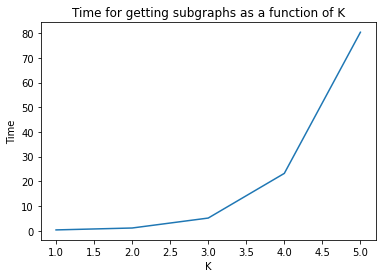

In [ ]:
import matplotlib.pyplot as plt
fig=plt.plot(x,y)
plt.xlabel('K')
plt.ylabel('Time')
plt.title("Time for getting subgraphs as a function of K")

In [52]:
def get_subgraphs2(my_dataset,all_data):
  start=time.time()
  for trial_graph in my_dataset:
    edge_index=trial_graph.x['edge_index'] #getting edges
    node_feat=trial_graph.x['node_feat']   #getting nodes
    edge_attr=trial_graph.x['edge_attr']   #getting edge attributes
    #removing 1 hot encoding on node features
    node_feat=np.array(node_feat)           
    node_feat=np.where(node_feat==1)[1]
    #getting unique codes
    unique_nodes=np.unique(node_feat)
    #removing 1 hot encoding on edge features
    edge_attr=np.array(edge_attr)
    edge_attr=np.where(edge_attr==1)[1]
    #getting number of nodes
    num_nodes=trial_graph.x['num_nodes']

    g1=nx.Graph()
    for i in range(num_nodes):
      g1.add_node(i,node_label=node_feat[i])

    for i in range(len(edge_index[0])):
      g1.add_edge(edge_index[0][i],edge_index[1][i],edge_label=edge_attr[i])

  # drawing the graph
    # pos = nx.spring_layout(g1)
    # nx.draw(
    #   g1, pos, edge_color='black', width=1, linewidths=1,
    #   node_size=500, node_color='pink', alpha=0.9,
    #   labels={node: node for node in g1.nodes()}
    # )
    # nx.draw_networkx_edge_labels(
    #   g1, pos,
    #   edge_labels=nx.get_edge_attributes(g1, 'edge_label'),
    #   font_color='red'
    # )
    data_point=[]
    for s in range (1,6):
      all_connected_subgraphs = []
      size=s
      norm=0
      for SG in (g1.subgraph(selected_nodes) for selected_nodes in itertools.combinations(g1, size)):
        if(nx.is_connected(SG)):
          all_connected_subgraphs.append(SG)
      
      
      store_count={}
      for i in range(len(all_connected_subgraphs)):
        hash=nx.weisfeiler_lehman_graph_hash(all_connected_subgraphs[i], edge_attr="edge_label",node_attr="node_label")
        if hash not in store_count:
          store_count[hash]=1
        else:
          store_count[hash]=store_count[hash]+1
        norm+=1

      #ans stores the counts of the different subgraphs for each data row in the dataset.
      #CODE FOR NORMALISATION
      # for key in store_count:
      #   store_count[key]/=norm
      data_point.append(store_count)
    # print(store_count)
    all_data.append(data_point)
  end=time.time()
  return all_data
  # print(end-start)

In [50]:
data_class0=[]
data_class1=[]
for node in dataset_pg_list:
  if node.x['y'][0]==0:
    data_class0.append(node)
  else:
    data_class1.append(node)

In [ ]:
print(len(data_class0))
print(len(data_class1))

63
125


In [53]:
all_data_class0=get_subgraphs2(data_class0,[])
all_data_class1=get_subgraphs2(data_class1,[])

In [ ]:
print(len(all_data_class0))

63


In [ ]:
#SIMILARITY WITHIN CLASS 0 AND CLASS SEPARATELY AND THEN INTER-CLASS SIMILARITY

In [54]:
from torch.utils.data import distributed
data=[]
distribution=[]
for i in range(len(all_data_class0)):
  sum=0
  for j in range(len(all_data_class0)):
    if(i==j):
      continue
    
    for k in range(len(all_data_class0[i])):
      graph1_data=all_data_class0[i][k]
      graph2_data=all_data_class0[j][k]
      for f in graph1_data:
        if f in graph2_data:
          sum=sum+graph1_data[f]*graph2_data[f]
  data.append(sum)
  distribution.append(sum)


26108.126984126986
11639.341798389803


(array([ 9.,  1.,  0., 18.,  8.,  2.,  4., 13.,  4.,  4.]),
 array([ 5698. ,  9837.9, 13977.8, 18117.7, 22257.6, 26397.5, 30537.4,
        34677.3, 38817.2, 42957.1, 47097. ]),
 <a list of 10 Patch objects>)

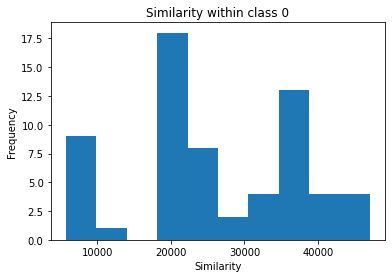

In [55]:
from statistics import mean,stdev
import matplotlib.pyplot as plt
mean_data=mean(data)
std_data=stdev(data)
print(mean_data)
print(std_data)
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title("Similarity within class 0")
plt.hist(distribution)

In [56]:
from torch.utils.data import distributed
data=[]
distribution=[]
for i in range(len(all_data_class1)):
  sum=0
  for j in range(len(all_data_class1)):
    if(i==j):
      continue
    
    for k in range(len(all_data_class1[i])):
      graph1_data=all_data_class1[i][k]
      graph2_data=all_data_class1[j][k]
      for f in graph1_data:
        if f in graph2_data:
          sum=sum+graph1_data[f]*graph2_data[f]
  data.append(sum)
  distribution.append(sum)


363640.24
214128.67326474367


(array([11., 40., 13., 19.,  3., 31.,  2.,  3.,  2.,  1.]),
 array([  17890. ,  122105.3,  226320.6,  330535.9,  434751.2,  538966.5,
         643181.8,  747397.1,  851612.4,  955827.7, 1060043. ]),
 <a list of 10 Patch objects>)

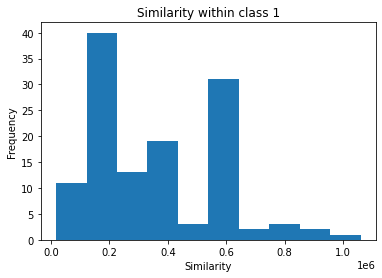

In [57]:
from statistics import mean,stdev
import matplotlib.pyplot as plt
mean_data=mean(data)
std_data=stdev(data)
print(mean_data)
print(std_data)
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title("Similarity within class 1")
plt.hist(distribution)


In [58]:
from torch.utils.data import distributed
data=[]
distribution=[]
for i in range(len(all_data_class1)):
  sum=0
  for j in range(len(all_data_class0)):
    if(i==j):
      continue
    
    for k in range(len(all_data_class1[i])):
      graph1_data=all_data_class1[i][k]
      graph2_data=all_data_class0[j][k]
      for f in graph1_data:
        if f in graph2_data:
          sum=sum+graph1_data[f]*graph2_data[f]
  data.append(sum)
  distribution.append(sum)


63815.656
31516.81635512965


(array([ 7., 11., 46., 15.,  6., 29.,  3.,  5.,  0.,  3.]),
 array([  6938. ,  22607.3,  38276.6,  53945.9,  69615.2,  85284.5,
        100953.8, 116623.1, 132292.4, 147961.7, 163631. ]),
 <a list of 10 Patch objects>)

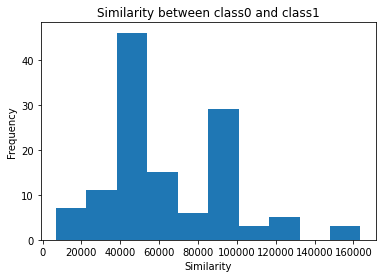

In [59]:
from statistics import mean,stdev
mean_data=mean(data)
std_data=stdev(data)
print(mean_data)
print(std_data)
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title("Similarity between class0 and class1")
plt.hist(distribution)

In [ ]:
#BELOW, I PLOT THE SIMILARITY AGAIN BUT THIS TIME I NORMALISED THE SIMILARITY AND ALSO I COMBINED THE DATA OF ALL GRAPHS OF SAME CLASS INSTEAD OF DOING SEPARATELY FOR CLASS0 AND CLASS1

In [37]:
from torch.utils.data import distributed
data=[]
distribution=[]
for i in range(len(all_data_class0)):
  
  for j in range(len(all_data_class0)):
    if(i==j):
      continue
    sum=0
    for k in range(len(all_data_class0[i])):
      graph1_data=all_data_class0[i][k]
      graph2_data=all_data_class0[j][k]
      
      for f in graph1_data:
        if f in graph2_data:
          sum+=graph1_data[f]*graph2_data[f]
    data.append(sum)
for i in range(len(all_data_class1)):
  
  for j in range(len(all_data_class1)):
    if(i==j):
      continue
    sum=0
    for k in range(len(all_data_class1[i])):
      graph1_data=all_data_class1[i][k]
      graph2_data=all_data_class1[j][k]
      
      for f in graph1_data:
        if f in graph2_data:
          sum+=graph1_data[f]*graph2_data[f]
    data.append(sum)
  # distribution.append(sum)

1.5307013479393607
0.5725527526873029


(array([1940.,  728., 3872., 4944., 3818., 1932., 1064.,  606.,  374.,
         128.]),
 array([0.36999662, 0.67913671, 0.9882768 , 1.29741689, 1.60655698,
        1.91569707, 2.22483716, 2.53397724, 2.84311733, 3.15225742,
        3.46139751]),
 <a list of 10 Patch objects>)

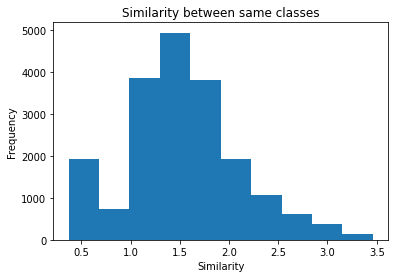

In [38]:
from statistics import mean,stdev
import matplotlib.pyplot as plt
mean_data=mean(data)
std_data=stdev(data)
print(mean_data)
print(std_data)
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title("Similarity between same classes")
plt.hist(data)

In [39]:
data=[]
distribution=[]
for i in range(len(all_data_class1)):
  
  for j in range(len(all_data_class0)):
    sum=0
    for k in range(len(all_data_class1[i])):
      graph1_data=all_data_class1[i][k]
      graph2_data=all_data_class0[j][k]
      
      for f in graph1_data:
        if f in graph2_data:
          sum=sum+graph1_data[f]*graph2_data[f]
    data.append(sum)
  # distribution.append(sum)

1.3013245138404004
0.47853113133117403


(array([1272.,  279., 1163., 2035., 1512.,  938.,  461.,  121.,   69.,
          25.]),
 array([0.37453527, 0.63581468, 0.89709409, 1.1583735 , 1.41965291,
        1.68093232, 1.94221173, 2.20349114, 2.46477055, 2.72604996,
        2.98732938]),
 <a list of 10 Patch objects>)

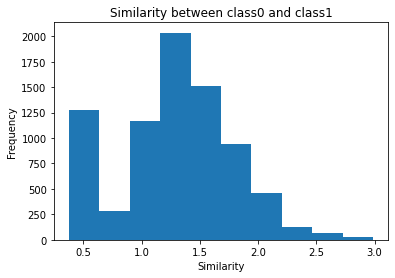

In [40]:
from statistics import mean,stdev
import matplotlib.pyplot as plt
mean_data=mean(data)
std_data=stdev(data)
print(mean_data)
print(std_data)
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title("Similarity between class0 and class1")
plt.hist(data)